In [1]:
import re
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.corpus import inaugural

In [2]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

porter    = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
wnl       = nltk.WordNetLemmatizer()

In [3]:
inaugural.fileids()[:4]

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt']

In [4]:
inaugural.words(inaugural.fileids()[0])

['Fellow', '-', 'Citizens', 'of', 'the', 'Senate', ...]

In [5]:
stop_words = set(stopwords.words('english'))

### 1. Stopwords


Remove all punctuation and strange unicode characters, and anything else think might be extraneous

In [6]:
# update the stop words
stop_words.update(['.','[',']','(',')',',','-',':','?','!','/', '...',';','$','"','.)',':"','\'','--',"[]!\#$%&'()*+,\-./:;<=>?@\[\\\]^_‘{|}~","0123456789"])

---
### 2. Read each inaugural address into an Pandas DataFrame

**2.1 Create a vocabulary as a set of all unique stemmed terms in the corpus**

In [7]:
vocab = set()

In [8]:
# creating vocab
sizedict = {}
for i in inaugural.fileids():
    sizedict[i]=0
    for j in inaugural.words(i): 
        list_word = list(j)
        for char in list_word:
            if ord(char) > 127:
                stop_words.update(j)
        if j not in stop_words:
            vocab.add(lancaster.stem(j))
            sizedict[i]+=1

In [9]:
len(vocab)

4602

**2.2 Use  vocabulary to read each inaugural address into a dataframe**

In [10]:
#print(df)
len(inaugural.fileids())
df = pd.DataFrame(index = inaugural.fileids(),columns = vocab, dtype=float)
df = df.fillna(0)

In [11]:
#doc_word = inaugural.words(inaugural.fileids())
for doc in inaugural.fileids():
    for word in inaugural.words(doc):
        if lancaster.stem(word) in df.columns:
            df.loc[doc,lancaster.stem(word)] += 1

---
### 3. Compute TF-IDF for the document-term matrix ###

**3.1. Write a function to compute term frequency (TF) for each document**


In [12]:
# compute term frequency
# inputs: wordvec is a series that contains, for a given doc, 
#                 the word counts for each term in the vocab
#         doclen  is the length of the document
# returns: a series with new term-frequencies (raw counts divided by doc length)
def computetf(wordvec,doclen):

    return  wordvec / doclen;

# Testing computetf
testing = pd.DataFrame()
for index, row in df.iterrows():
    newrow = computetf(row,sizedict[index])
    testing = testing.append(newrow)

**3.2 Write a function to comput inverse document frequency**


In [13]:
import math 

def computeidf(df):
    n = len(df.index)
    idf = {}
    for term in df.columns:
        count = 0
        for index in df.index:
            if df.loc[index,term] != 0:
                count += 1
        idf[term] = math.log(n /count)
    return idf



**Create a new dataframe and populate it with the TF-IDF values for each document-term combination**

In [14]:
newdf = pd.DataFrame()

idfdict = computeidf(df)

cols = df.columns
for index, row in df.iterrows():
    newrow = computetf(row,sizedict[index])
    for c in cols:
        newrow[c] = newrow[c]*idfdict[c]
    newdf = newdf.append(newrow)

In [15]:
newdf.shape

(58, 4602)

---
### 4. Using TF-IDF values, find and rank order the 3 closest inaugural addresses to Donald Trump's 2017 address, measured by cosine similarity

In [16]:
# President Trump's address is 57

**4.1 Create an array called dist that contains the cosine similarity and each of the inaugural addresses**

In [17]:
from math import sqrt 
import numpy as np

d1 = newdf.iloc[57,:]
sum_d1 = 0
dist = {}        


for i in d1:
    sum_d1 = sum_d1 + pow(i,2)
d1_norm = sqrt(sum_d1)

for index,row in newdf.iterrows():
    d2 = row
    sum_d2 = 0
    for j in d1:
        sum_d2 = sum_d2 + pow(j,2)
    d2_norm = sqrt(sum_d2)
    dist[index] =(np.dot(d1,d2) / (d1_norm*d2_norm))

**4.2 Find the 3 closest associated inaugural address, when measured by cosign similarity

In [18]:
sort_dist = sorted(dist.items(),reverse=True,key=lambda item: item[1])

In [19]:
sort_dist

[('2017-Trump.txt', 0.9999999999999992),
 ('2013-Obama.txt', 0.2073733238682776),
 ('1993-Clinton.txt', 0.2018806481101519),
 ('1997-Clinton.txt', 0.17400555565421544),
 ('1989-Bush.txt', 0.16411052890971806),
 ('1969-Nixon.txt', 0.1613213553218048),
 ('2009-Obama.txt', 0.15870041510601035),
 ('1981-Reagan.txt', 0.14325126155396137),
 ('2001-Bush.txt', 0.14006640766907785),
 ('2005-Bush.txt', 0.13547742137997718),
 ('1973-Nixon.txt', 0.12723528730855857),
 ('1985-Reagan.txt', 0.12519026729605637),
 ('1977-Carter.txt', 0.10834524642339469),
 ('1961-Kennedy.txt', 0.10324052172236514),
 ('1945-Roosevelt.txt', 0.10085435069129443),
 ('1793-Washington.txt', 0.09424170913306848),
 ('1937-Roosevelt.txt', 0.09099213670888447),
 ('1957-Eisenhower.txt', 0.08759975169573302),
 ('1965-Johnson.txt', 0.0857191898010488),
 ('1941-Roosevelt.txt', 0.08443110283782883),
 ('1913-Wilson.txt', 0.08442230991348655),
 ('1921-Harding.txt', 0.07294309623151449),
 ('1953-Eisenhower.txt', 0.07230577565704195),
 

---
### 5. Compute the first two principal components of the TF-IDF matrix, and plot each document along each of the PCA components

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [21]:
# PCA
pca = PCA(n_components = 2)
X = pca.fit_transform(newdf)

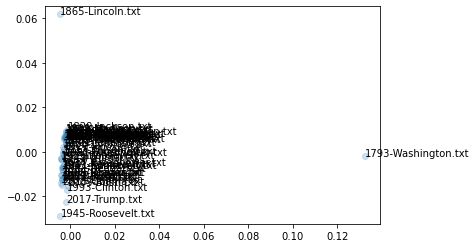

In [22]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.axis('equal');
for i in range(0,58):
    plt.text(X[i,0],X[i,1],inaugural.fileids()[i])